# Project 1. HMM 적용하여 데이터 모델링 해보기

## Hidden Markov Model

* https://web.stanford.edu/~jurafsky/slp3/A.pdf
  
## Character Trajactories Data Set
* Import mat-formatted data
  * `mixoutALL_shifted.mat`
* Data Features
  * Data Set Characteristics: Time-Series
  * Number of Instances: 2858
  * Attribute Characteristics: Real
  * Number of Attributes: 3
  * Missing Values? N/A
  * Each character sample is a 3-dimensional pen tip velocity trajectory. This is contained in matrix format, with 3 rows and T columns where T is the length of the character sample.
  * 3 Dimensions were kept - x, y, and pen tip force.
  * http://archive.ics.uci.edu/ml/datasets/Character+Trajectories

In [117]:
from scipy import io
import matplotlib.pyplot as plt
import numpy as np

mat_file = io.loadmat('./mixoutALL_shifted (1).mat')

# print(mat_file['consts'].dtype)
consts = mat_file['consts'][0,0]
mixouts = mat_file['mixout'][0]

keys = np.squeeze(consts['key'][0])
charlabels = consts['charlabels'][0] - 1

num_keys = keys.size
num_mixouts = mixouts.shape[0]

print('num_mixouts:', num_mixouts)
print('num_keys:', num_keys)
for i in range(num_keys):
    print(keys[i], end='')

for i in range(num_mixouts):
    mixouts[i] = mixouts[i].T

print(mixouts[0].shape)

# print()
# for i in range(len(charlabels)):
#     print(i, charlabels[i])

num_mixouts: 2858
num_keys: 20
['a']['b']['c']['d']['e']['g']['h']['l']['m']['n']['o']['p']['q']['r']['s']['u']['v']['w']['y']['z'](178, 3)


0
['a']


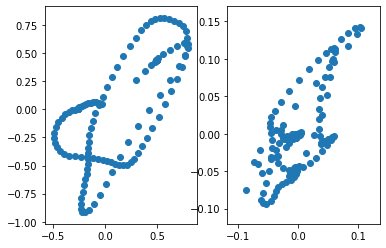

100
['b']


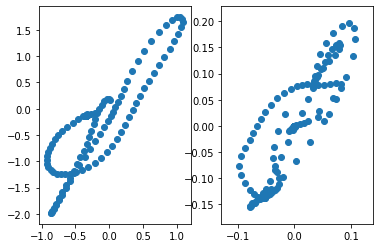

200
['c']


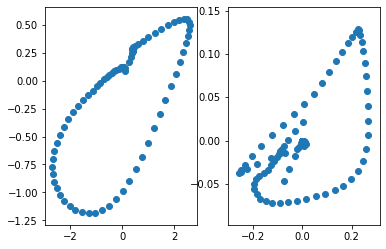

300
['d']


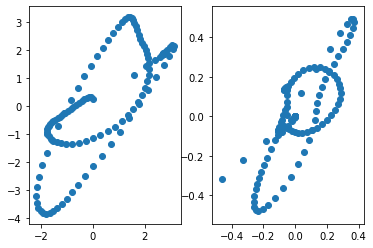

400
['e']


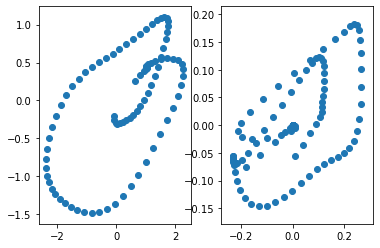

500
['h']


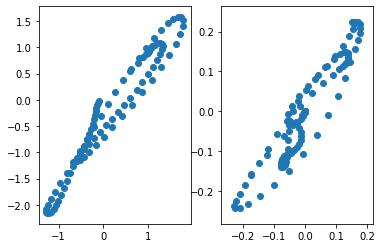

600
['l']


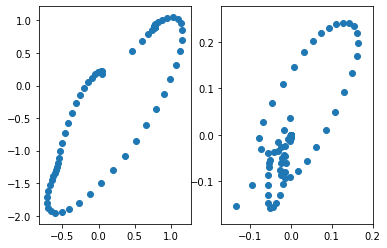

700
['n']


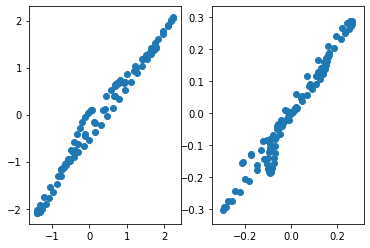

800
['o']


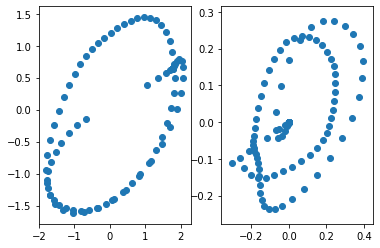

900
['q']


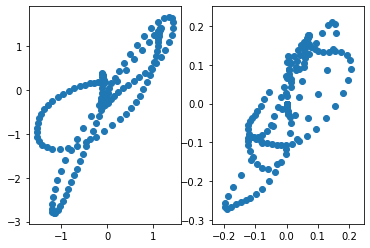

1000
['r']


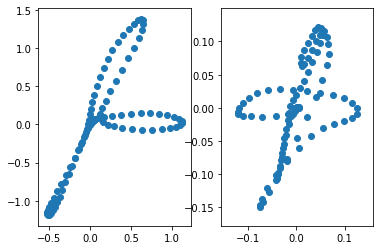

1100
['u']


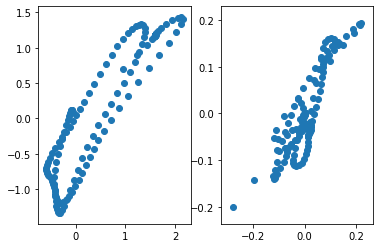

1200
['v']


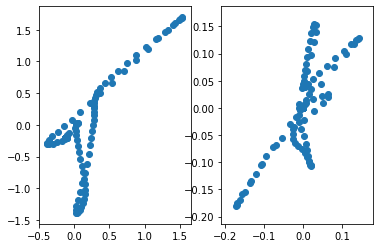

1300
['y']


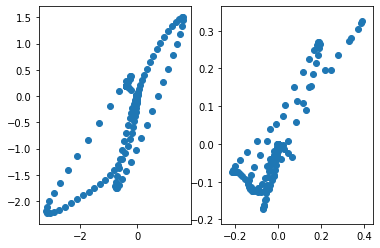

1400
['z']


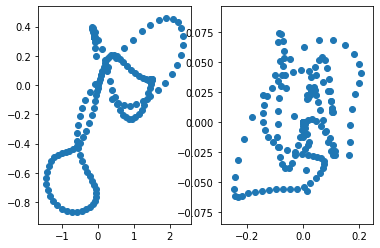

1500
['a']


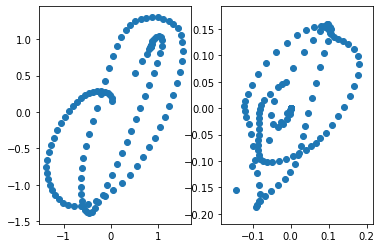

1600
['c']


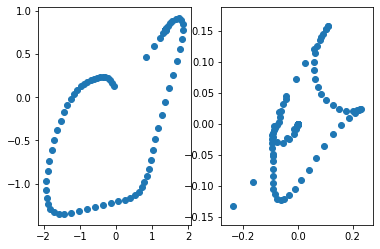

1700
['d']


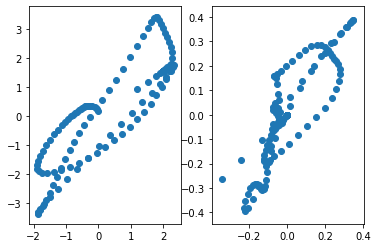

1800
['e']


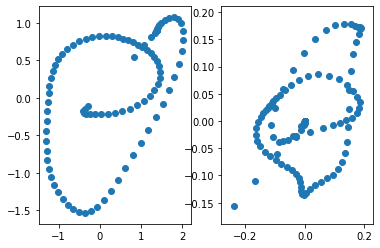

1900
['h']


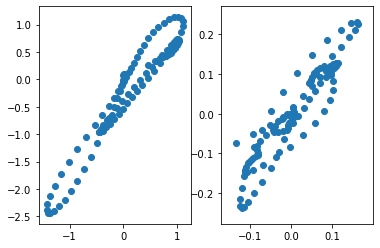

2000
['l']


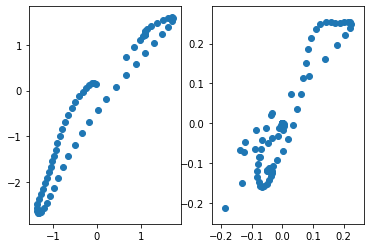

2100
['m']


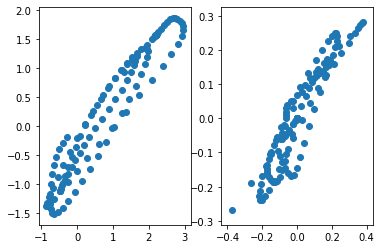

2200
['o']


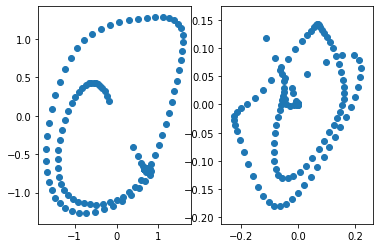

2300
['p']


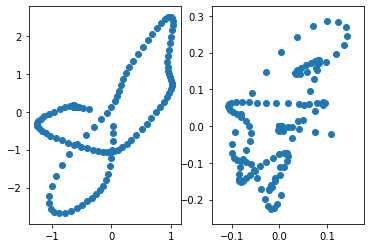

2400
['r']


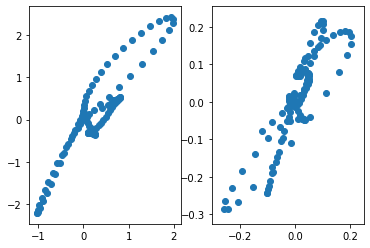

2500
['u']


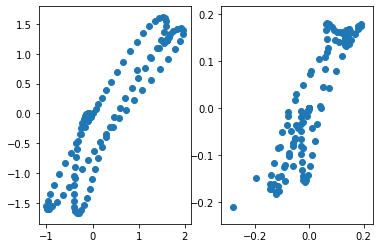

2600
['v']


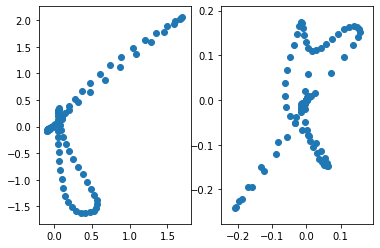

2700
['w']


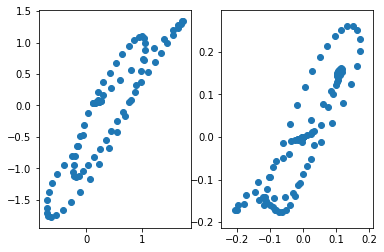

2800
['z']


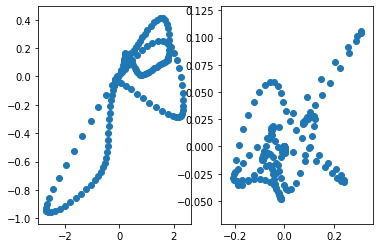

In [127]:
def get_unit_vector(coords):
    vec_size = np.sqrt(np.dot(coords, coords))
    if vec_size == 0:
        return coords / vec_size
    return coords

def get_velocity(disp):
    mask = (disp[:,0] != 0) | (disp[:,1] != 0)
    disp = disp[mask]
    
    vel = np.zeros(disp.shape)
    for i in range(1, disp.shape[0]):
        vel[i] = disp[i] - disp[i-1]
    
    plt.subplot('121')
    plt.scatter(disp[:,0], disp[:,1])
    plt.subplot('122')
    plt.scatter(vel[:,0], vel[:,1])
    plt.show()
    
# print(get_unit_vector([0, 1]))
i = 500
for i in range(0, charlabels.shape[0], 100):
    print(i)
    print(keys[charlabels[i]])
    get_velocity(mixouts[i][:,:2])